In [1]:
#We get all dependencis we need for a Random Forest
#If you need a module do: "!pip install [module_name]""
import numpy as np
import pandas as pd
import secrets
import matplotlib.pylab as plt
import itertools
import pydot
import pickle
import sys

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from collections import Counter
from subprocess import call
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

In [2]:
# Get our `labelled` table as df - This is going to be our training set
# Note that we are removing a URL because we will use that URL for testing

db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)
df_send = pd.read_sql('SELECT `url`, `start`, `end`, `isHighlight` FROM labelled WHERE isHighlight IS NOT NULL', con=db_conn)
df = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight IS NOT NULL', con=db_conn)
df_test = pd.read_sql('SELECT `isHighlight`, `pred_highlight_rf`, `prob_highlight_nn`, `pred_highlight_nn` FROM predictions_table', con=db_conn)
df_vis = pd.read_sql('SELECT * FROM labelled WHERE isHighlight IS NOT NULL', con=db_conn)

print('Number of Rows:', len(df.index))


Number of Rows: 19806


In [3]:
#Get model from file
rf_model = pickle.load(open('rf_100t.sav', 'rb'))
nn_model = pickle.load(open('nn_2layers_0.5.sav', 'rb'))

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [4]:
y_test = np.array(df.pop('isHighlight'))
X_test = df
X_test.head()

,pitch,amplitude,subjectivity,polarity,pred_excitement
0,49.9597,0.000801,0.000000,0.000000,0
1,58.7970,0.000655,0.000000,0.000000,1
2,61.5320,-0.000205,0.000000,0.000000,1
3,59.4878,0.000786,0.026786,-0.008929,1
4,59.9587,-0.000265,0.000000,0.000000,1


In [5]:
rf_predictions = rf_model.predict(X_test)
nn_probs = nn_model.predict(X_test)
nn_predictions = nn_model.predict_classes(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [6]:
# This function is used to evaluate our Random Forest models:
def evaluate_model(predictions, y_test):
    """Compare machine learning model to baseline performance."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)

    
    for metric in ['recall', 'precision']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}')


In [7]:
# This function outputs a confusion matrix for us
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

RANDOM FOREST MODEL
Recall Baseline: 1.0 Test: 0.83
Precision Baseline: 0.15 Test: 0.68
Confusion matrix, without normalization
[[15710  1170]
 [  496  2430]]


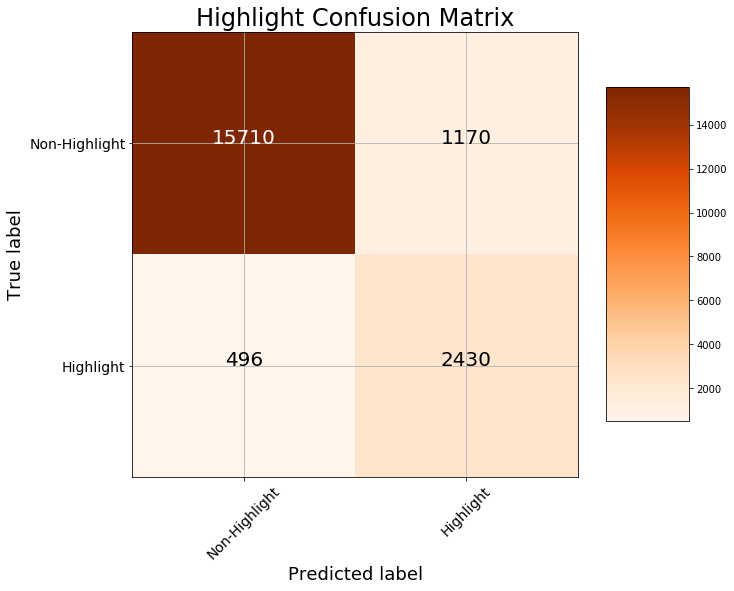

In [8]:
print("RANDOM FOREST MODEL")
evaluate_model(rf_predictions, y_test)
# Output Confusion Matrix given function above
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

NEURAL NETWORK MODEL
Recall Baseline: 1.0 Test: 0.8
Precision Baseline: 0.15 Test: 0.3
Confusion matrix, without normalization
[[11375  5505]
 [  592  2334]]


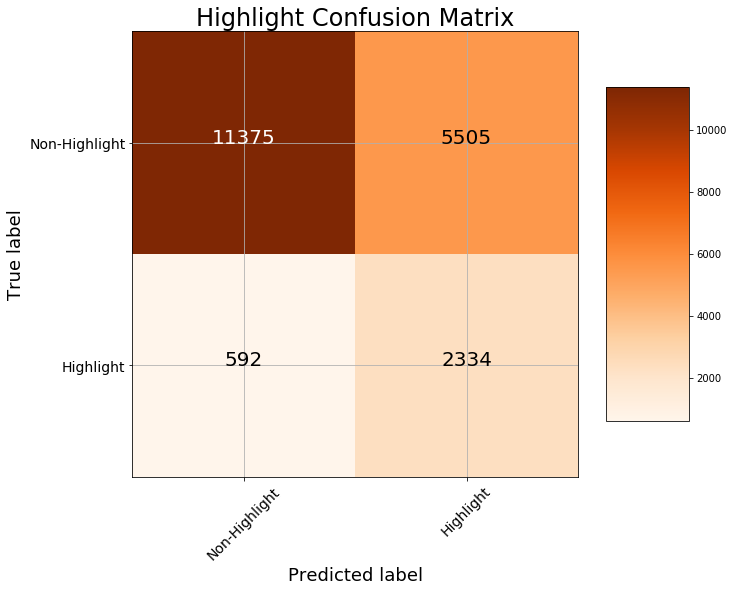

In [9]:
print("NEURAL NETWORK MODEL")
evaluate_model(nn_predictions, y_test)
# Output Confusion Matrix given function above
cm = confusion_matrix(y_test, nn_predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

In [10]:
# Create Columns based on predictions
df_send['pred_highlight_rf'] = rf_predictions
df_send['prob_highlight_nn'] = nn_probs
df_send['pred_highlight_nn'] = nn_predictions

In [11]:
#Send updated table to db
df_send.to_sql("predictions_table", con=db_conn, if_exists='replace')

In [12]:
db_conn.dispose()

In [13]:
# NOW WE WILL DO VISUALIZATION TESTING/VALIDATING
# sample 100 random clips to classify
dataset = df_vis.sample(100)

In [14]:
# classify using the models
y_predict_rf = rf_model.predict(dataset[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']])
y_predict_nn = nn_model.predict_classes(dataset[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']])
dataset['y_predict_rf'] = y_predict_rf
dataset['y_predict_nn'] = y_predict_nn

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [15]:
# get youtube embeded url
def formatYoutubeUrl(url, start, end):
  embed_url = url.replace("watch?v=", "embed/")
  params = "?start={:}&end={:}&autoplay=1".format(start, end)
  return embed_url + params

def printUrls(df):
    for idx, row in df.iterrows():
        print(formatYoutubeUrl(row['url'], row['start'], row['end']))

In [16]:
# all non-highlight clips
non_highlight_rf = dataset[dataset['y_predict_rf'] == 0]
non_highlight_nn = dataset[dataset['y_predict_nn'] == 0]

# all non-highlight clips
highlight_rf = dataset[dataset['y_predict_rf'] == 1]
highlight_nn = dataset[dataset['y_predict_nn'] == 1]

# print URLS  (only 10 per category)
print('=== NON-HIGHLIGHT RF ===')
printUrls(non_highlight_rf[:10])

print('=== HIGHLIGHT RF ===')
printUrls(highlight_rf[:10])

print('=== NON-HIGHLIGHT NN ===')
printUrls(non_highlight_nn[:10])

print('=== HIGHLIGHT NN ===')
printUrls(highlight_nn[:10])

=== NON-HIGHLIGHT RF ===
https://www.youtube.com/embed/J16IWnr_P8o?start=3676&end=3680&autoplay=1
https://www.youtube.com/embed/jQYSNq4qw18?start=1162&end=1166&autoplay=1
https://www.youtube.com/embed/J16IWnr_P8o?start=5314&end=5318&autoplay=1
https://www.youtube.com/embed/jQYSNq4qw18?start=2952&end=2956&autoplay=1
https://www.youtube.com/embed/kgitmggEgrA?start=726&end=730&autoplay=1
https://www.youtube.com/embed/J16IWnr_P8o?start=6092&end=6096&autoplay=1
https://www.youtube.com/embed/XT5Cn6jg-IQ?start=1872&end=1876&autoplay=1
https://www.youtube.com/embed/-5NzaAt_wY0?start=452&end=456&autoplay=1
https://www.youtube.com/embed/J16IWnr_P8o?start=386&end=390&autoplay=1
https://www.youtube.com/embed/pybORD2OaMY?start=1944&end=1948&autoplay=1
=== HIGHLIGHT RF ===
https://www.youtube.com/embed/0AlFcix7aaY?start=878&end=882&autoplay=1
https://www.youtube.com/embed/XT5Cn6jg-IQ?start=252&end=256&autoplay=1
https://www.youtube.com/embed/XT5Cn6jg-IQ?start=1168&end=1172&autoplay=1
https://www.you

In [17]:
# try running prediction on 1 video
youtubeUrl = 'https://www.youtube.com/watch?v=-5NzaAt_wY0' # this url was chosen at random
dataset_by_url = df_vis[df_vis['url'] == youtubeUrl].copy()

In [18]:
# classify the new video sections using different models
y_predict_rf = rf_model.predict(dataset_by_url[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']])
dataset_by_url['y_predict_rf'] = y_predict_rf
y_predict_nn = nn_model.predict_classes(dataset_by_url[['pitch', 'amplitude', 'subjectivity', 'polarity', 'pred_excitement']])
dataset_by_url['y_predict_nn'] = y_predict_nn

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [19]:
for idx, row in dataset_by_url.iterrows():
    print(formatYoutubeUrl(row['url'], row['start'], row['end']), "predicted RF: " ,row['y_predict_rf'], "predicted NN: " ,row['y_predict_nn'])

https://www.youtube.com/embed/-5NzaAt_wY0?start=0&end=4&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2&end=6&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=4&end=8&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=6&end=10&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=8&end=12&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=10&end=14&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=12&end=16&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=14&end=18&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=16&end=20&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=18&end=22&autoplay=1 predicted RF

https://www.youtube.com/embed/-5NzaAt_wY0?start=588&end=592&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=590&end=594&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=592&end=596&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=594&end=598&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=596&end=600&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=598&end=602&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=600&end=604&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=602&end=606&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=604&end=608&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=606&end

https://www.youtube.com/embed/-5NzaAt_wY0?start=1090&end=1094&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1092&end=1096&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1094&end=1098&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1096&end=1100&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1098&end=1102&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1100&end=1104&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1102&end=1106&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1104&end=1108&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1106&end=1110&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt

https://www.youtube.com/embed/-5NzaAt_wY0?start=1558&end=1562&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1560&end=1564&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1562&end=1566&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1564&end=1568&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1566&end=1570&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1568&end=1572&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1570&end=1574&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1572&end=1576&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=1574&end=1578&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt

https://www.youtube.com/embed/-5NzaAt_wY0?start=2088&end=2092&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2090&end=2094&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2092&end=2096&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2094&end=2098&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2096&end=2100&autoplay=1 predicted RF:  0 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=2098&end=2102&autoplay=1 predicted RF:  1 predicted NN:  1
https://www.youtube.com/embed/-5NzaAt_wY0?start=2100&end=2104&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2102&end=2106&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt_wY0?start=2104&end=2108&autoplay=1 predicted RF:  0 predicted NN:  0
https://www.youtube.com/embed/-5NzaAt

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def secondsToTime(secs):
    m, s = divmod(secs, 60)
    return "{:}:{:}".format(m, s)

def realTimeHypeGraph(dataset):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()

    x = []
    y1 = []
    y2 = []

    for idx, row in dataset.iterrows():
        ax.clear()
        ax.set_ylim([-0.5, 2.5])
        
        videoTime = row['start'] / 60
        x.append(videoTime)
        y1.append(row['y_predict_rf'])
        y2.append(row['y_predict_nn'] + 0.02)

        ax.plot(x[-20:], y1[-20:], label='random_forest', alpha=0.7)
        ax.plot(x[-20:], y2[-20:], label='neural_network', alpha=0.7)
        
        plt.xlabel('Time (s)')
        plt.ylabel('Highlight')
        plt.legend()
        
        fig.canvas.draw()
        time.sleep(2)

In [21]:
from IPython.display import HTML

youtubeEmbedUrl = youtubeUrl.replace('watch?v=', 'embed/')
# Youtube
HTML("<iframe width='560' height='315' src='{:}'</iframe>".format(youtubeEmbedUrl))

C:\Users\eldri\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<IPython.core.display.Javascript object>


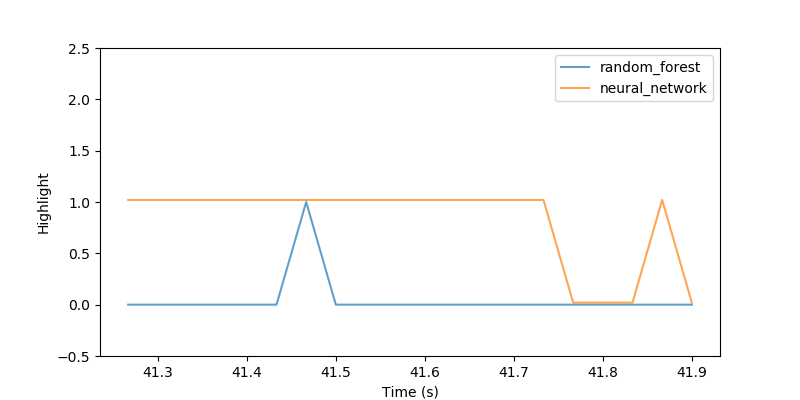

In [22]:
# run this cell right before you click play on the youtube video
dataset = dataset_by_url[dataset_by_url['start'] >= 1140] # you can customize the start time here
realTimeHypeGraph(dataset)

In [23]:
y_predict_nn

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])